<a href="https://colab.research.google.com/github/hannesstuehrenberg/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/08-1SHXXXX_football_analytics/projects/08-1SHXXXX_football_analytics/notebooks/05_model_training_and_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install mplsoccer

In [3]:
#Import necessary libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer import VerticalPitch
from mplsoccer import Sbopen
from tqdm import tqdm
import gdown

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Initialize parser
parser = Sbopen()


5. Model Training and Evaluation

* Training process
* Model evaluation (metrics, plots, performance)
* Cross-validation or uncertainty quantification


In [4]:
file_id = '1_WstcnGf_tUzWBj8XTN104EOkFlF5UN_'
url = f'https://drive.google.com/uc?id={file_id}'
shots_master_df = pd.read_csv(url)

print(shots_master_df.shape)

(79966, 67)


In [5]:
shots_master_df = shots_master_df.drop_duplicates()

print(shots_master_df.shape)

(79862, 67)


In [6]:
shots_master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79862 entries, 0 to 79965
Data columns (total 67 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           79862 non-null  object 
 1   index                        79862 non-null  int64  
 2   match_id                     79862 non-null  int64  
 3   period                       79862 non-null  int64  
 4   timestamp                    79862 non-null  object 
 5   team_id                      79862 non-null  int64  
 6   team_name                    79862 non-null  object 
 7   player_id                    79862 non-null  float64
 8   player_name                  79862 non-null  object 
 9   position_id                  79862 non-null  float64
 10  position_name                79862 non-null  object 
 11  x                            79862 non-null  float64
 12  y                            79862 non-null  float64
 13  end_x                

In [7]:
feature_columns = [
    'distance_to_goal',
    'angle_to_goal_deg',
    'opponents_in_way',
    'teammates_in_way',
    'with_dominant_foot',
    'shot_first_time',
    'shot_one_on_one',
    'shot_open_goal',
    'technique_Backheel',
    'technique_Diving Header',
    'technique_Half Volley',
    'technique_Lob',
    'technique_Normal',
    'technique_Overhead Kick',
    'technique_Volley',
    'subtype_Free Kick',
    'subtype_Open Play',
    'subtype_Penalty',
    'is_header'
]

from sklearn.model_selection import train_test_split

X = shots_master_df[feature_columns]
y = shots_master_df['goal']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

print("\nGoal distribution in training set:")
print(y_train.value_counts(normalize=True))

print("\nGoal distribution in test set:")
print(y_test.value_counts(normalize=True))




Training set size: 63889 samples
Test set size: 15973 samples

Goal distribution in training set:
goal
0    0.888087
1    0.111913
Name: proportion, dtype: float64

Goal distribution in test set:
goal
0    0.888124
1    0.111876
Name: proportion, dtype: float64


In [8]:
numerical_features = [
    'distance_to_goal',
    'angle_to_goal_deg',
    'opponents_in_way',
    'teammates_in_way',
    'with_dominant_foot'
]

binary_features = [
    'shot_first_time',
    'shot_one_on_one',
    'shot_open_goal',
    'technique_Backheel',
    'technique_Diving Header',
    'technique_Half Volley',
    'technique_Lob',
    'technique_Normal',
    'technique_Overhead Kick',
    'technique_Volley',
    'subtype_Free Kick',
    'subtype_Open Play',
    'subtype_Penalty',
    'is_header'
]

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('bin', 'passthrough', binary_features)
    ]
)


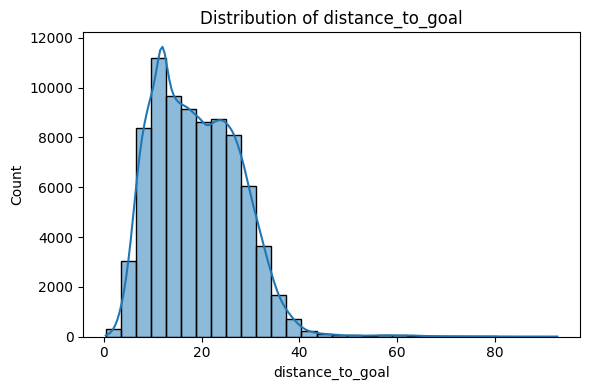

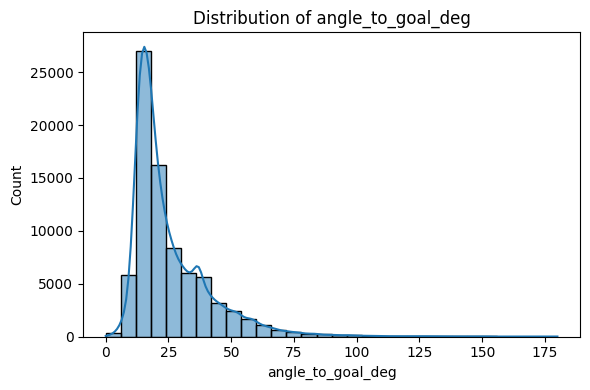

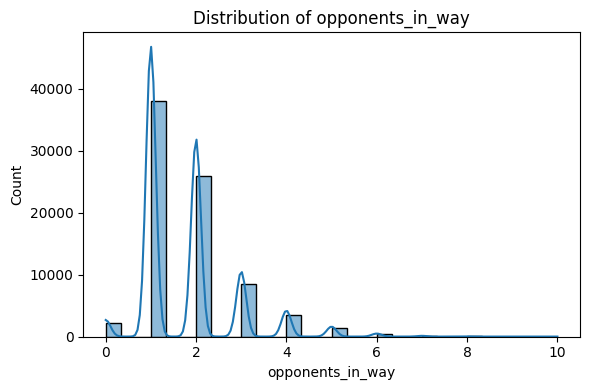

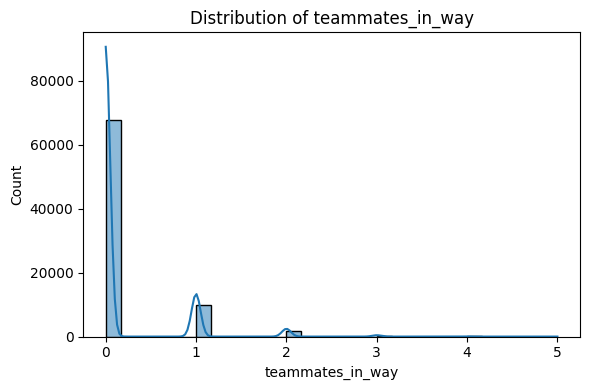

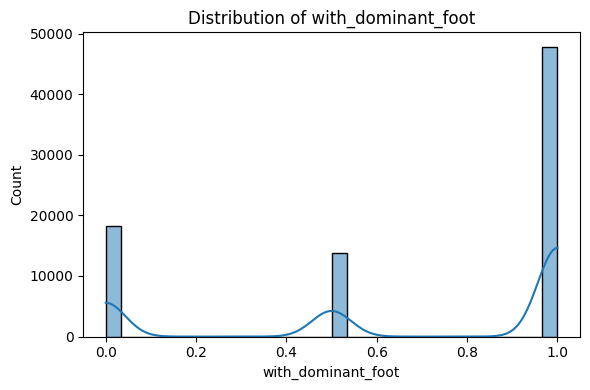

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(shots_master_df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


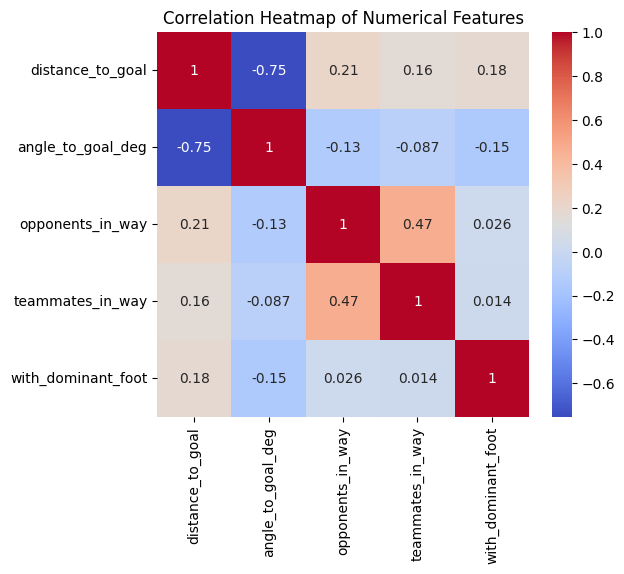

In [ ]:
corr = shots_master_df[numerical_features].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X_num = shots_master_df[numerical_features]

X_num_const = sm.add_constant(X_num)

In [ ]:
import statsmodels.api as sm

vif_data = pd.DataFrame()
vif_data["Feature"] = X_num.columns
vif_data["VIF"] = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]

print(vif_data)

              Feature       VIF
0    distance_to_goal  4.581543
1   angle_to_goal_deg  2.315673
2    opponents_in_way  4.805525
3    teammates_in_way  1.457450
4  with_dominant_foot  3.648898


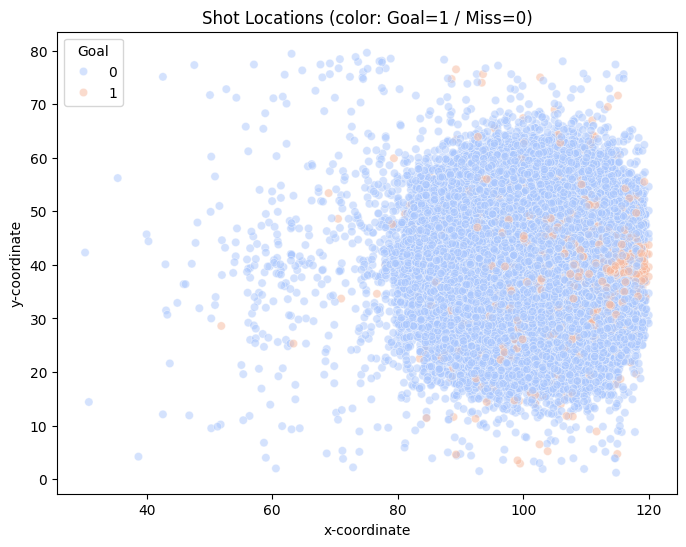

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=shots_master_df,
    x='x', y='y',
    hue='goal',
    palette='coolwarm',
    alpha=0.5
)
plt.title("Shot Locations (color: Goal=1 / Miss=0)")
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.legend(title='Goal')
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipeline_logistic = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000,
        solver='lbfgs',
        class_weight='balanced',
        random_state=42
    ))
])

In [ ]:
pipeline_logistic.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['distance_to_goal',
                                                   'angle_to_goal_deg',
                                                   'opponents_in_way',
                                                   'teammates_in_way',
                                                   'with_dominant_foot']),
                                                 ('bin', 'passthrough',
                                                  ['shot_first_time',
                                                   'shot_one_on_one',
                                                   'shot_open_goal',
                                                   'technique_Backheel',
                                                   'technique_Diving Header',
                                                   'technique_Half Volley',
                                                   'technique_Lob',
                                                   'technique_Normal',
                                                   'technique_Overhead Kick',
                                                   'technique_Volley',
                                                   'subtype_Free Kick',
                                                   'subtype_Open Play',
                                                   'subtype_Penalty',
                                                   'is_header'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss

y_pred_proba = pipeline_logistic.predict_proba(X_test)[:, 1]

#Predict class labels with default threshold 0.5
y_pred = pipeline_logistic.predict(X_test)

In [ ]:
y_pred = pipeline_logistic.predict(X_test)
y_pred_proba = pipeline_logistic.predict_proba(X_test)[:, 1]

#Metrics:
auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred)
ll = log_loss(y_test, y_pred_proba)

print(f"AUC: {auc:.3f}")
print(f"Accuracy: {acc:.3f}")
print(f"Log-Loss: {ll:.3f}")

AUC: 0.807
Accuracy: 0.761
Log-Loss: 0.523


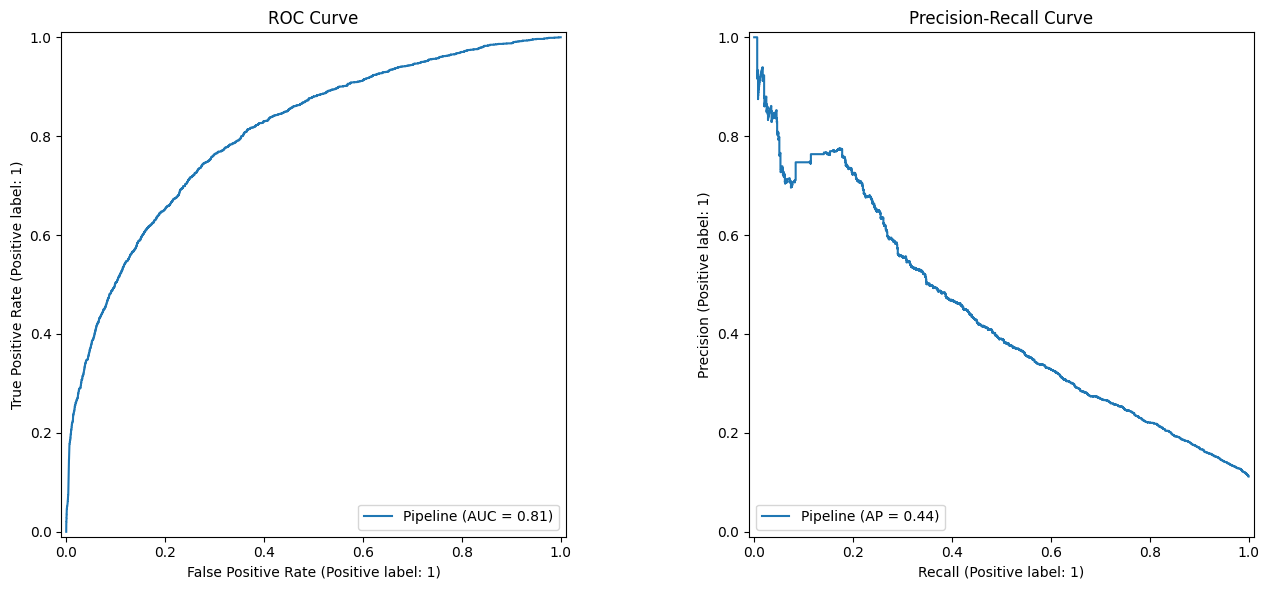

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

roc_display = RocCurveDisplay.from_estimator(pipeline_logistic, X_test, y_test, ax=axes[0])
axes[0].set_title("ROC Curve")

pr_display = PrecisionRecallDisplay.from_estimator(pipeline_logistic, X_test, y_test, ax=axes[1])
axes[1].set_title("Precision-Recall Curve")

plt.tight_layout()
plt.show()

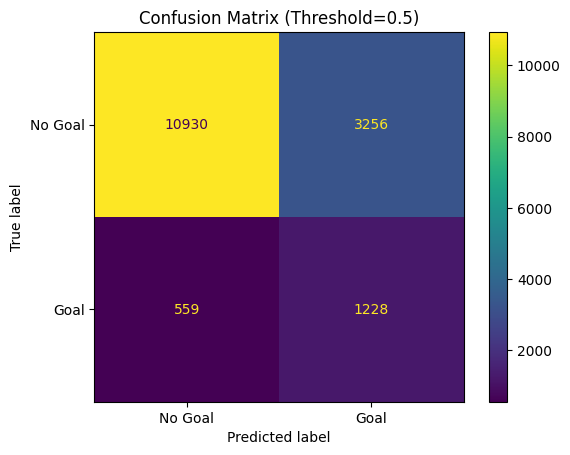

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["No Goal", "Goal"]).plot(values_format='d')
plt.title("Confusion Matrix (Threshold=0.5)")
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.0, 1.01, 0.05)
precisions, recalls, f1s = [], [], []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_thresh, zero_division=0))
    f1s.append(f1_score(y_test, y_pred_thresh, zero_division=0))

optimal_idx = np.argmax(f1s)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Precision at optimal threshold: {precisions[optimal_idx]:.3f}")
print(f"Recall at optimal threshold: {recalls[optimal_idx]:.3f}")
print(f"F1 at optimal threshold: {f1s[optimal_idx]:.3f}")


Optimal threshold: 0.70
Precision at optimal threshold: 0.447
Recall at optimal threshold: 0.432
F1 at optimal threshold: 0.439


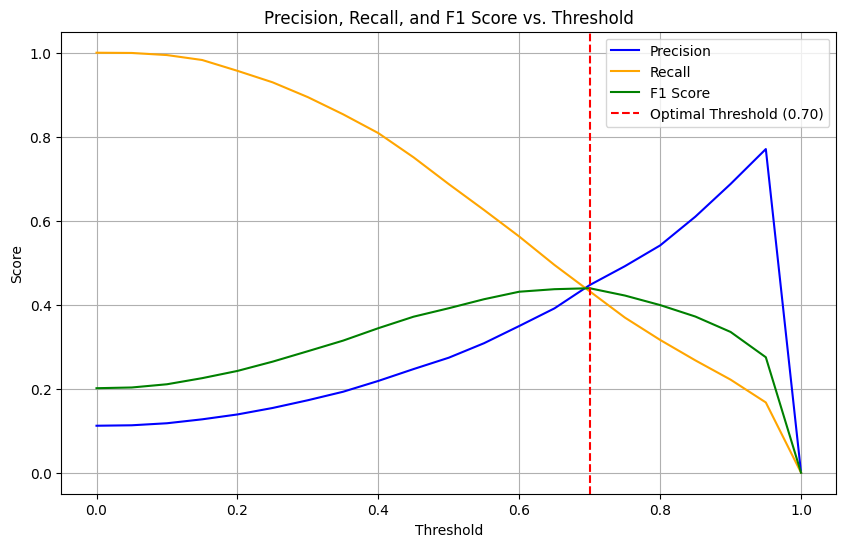

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='orange')
plt.plot(thresholds, f1s, label='F1 Score', color='green')
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()


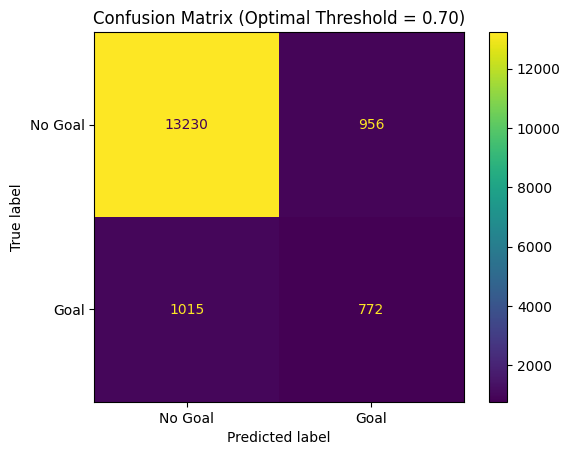

In [ ]:
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_optimal)

# Plot it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Goal", "Goal"])
disp.plot(values_format='d')
plt.title(f"Confusion Matrix (Optimal Threshold = {optimal_threshold:.2f})")
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

final_precision = precision_score(y_test, y_pred_optimal, zero_division=0)
final_recall = recall_score(y_test, y_pred_optimal, zero_division=0)
final_f1 = f1_score(y_test, y_pred_optimal, zero_division=0)

print(f"Final Precision: {final_precision:.3f}")
print(f"Final Recall: {final_recall:.3f}")
print(f"Final F1 Score: {final_f1:.3f}")

Final Precision: 0.447
Final Recall: 0.432
Final F1 Score: 0.439


In [ ]:
# Recreate final feature list after preprocessing
num_features_scaled = numerical_features  # scaler doesn't change names
bin_features = binary_features            # passthrough leaves names unchanged

all_features = num_features_scaled + bin_features


In [ ]:
import pandas as pd

# Extract coefficients from trained logistic regression
coefficients = pipeline_logistic.named_steps['classifier'].coef_[0]

# Create DataFrame for easier viewing
coef_df = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print(coef_df)


                    Feature  Coefficient
11            technique_Lob     1.705519
9   technique_Diving Header     1.065646
17          subtype_Penalty     0.953943
7            shot_open_goal     0.773606
1         angle_to_goal_deg     0.526426
15        subtype_Free Kick     0.510365
6           shot_one_on_one     0.473324
12         technique_Normal     0.316125
5           shot_first_time     0.119083
4        with_dominant_foot     0.030745
3          teammates_in_way    -0.001415
10    technique_Half Volley    -0.192558
14         technique_Volley    -0.327990
2          opponents_in_way    -0.359868
13  technique_Overhead Kick    -0.807609
0          distance_to_goal    -0.820717
16        subtype_Open Play    -1.054239
8        technique_Backheel    -1.349063
18                is_header    -1.593817


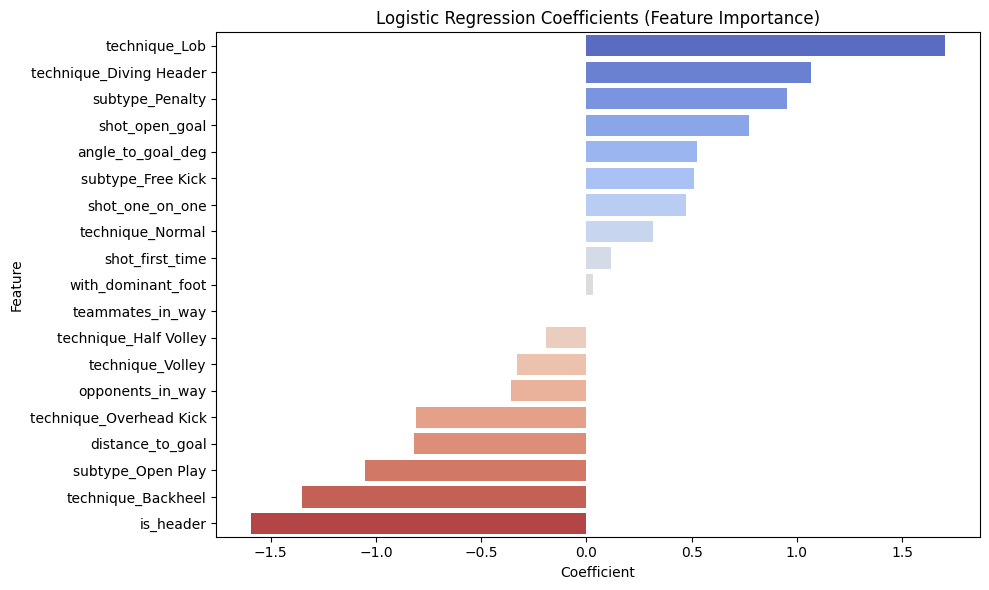

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='coolwarm')
plt.title("Logistic Regression Coefficients (Feature Importance)")
plt.tight_layout()
plt.show()


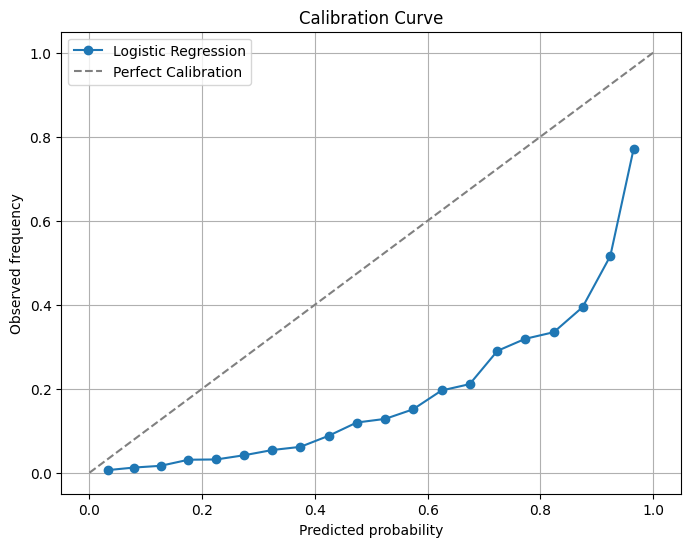

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Compute calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=20, strategy='uniform')

plt.figure(figsize=(8,6))
plt.plot(prob_pred, prob_true, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_pipeline_logistic = CalibratedClassifierCV(
    estimator=pipeline_logistic,  # your trained pipeline
    method='sigmoid',             # or 'isotonic'
    cv=5                          # internal cross-validation folds for calibration
)

calibrated_pipeline_logistic.fit(X_train, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=Pipeline(steps=[('preprocessor',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   StandardScaler(),
                                                                                   ['distance_to_goal',
                                                                                    'angle_to_goal_deg',
                                                                                    'opponents_in_way',
                                                                                    'teammates_in_way',
                                                                                    'with_dominant_foot']),
                                                                                  ('bin',
                                                                                   'passthrough',
                                                                                   ['shot_first_time',
                                                                                    'shot_one_on_one',
                                                                                    'shot_open_goal',
                                                                                    'technique_Backheel',
                                                                                    'technique_Diving '
                                                                                    'Header',
                                                                                    'technique_Half '
                                                                                    'Volley',
                                                                                    'technique_Lob',
                                                                                    'technique_Normal',
                                                                                    'technique_Overhead '
                                                                                    'Kick',
                                                                                    'technique_Volley',
                                                                                    'subtype_Free '
                                                                                    'Kick',
                                                                                    'subtype_Open '
                                                                                    'Play',
                                                                                    'subtype_Penalty',
                                                                                    'is_header'])])),
                                                 ('classifier',
                                                  LogisticRegression(class_weight='balanced',
                                                                     max_iter=1000,
                                                                     random_state=42))]))

In [ ]:
# Predict probabilities with calibrated model
y_pred_proba_calibrated = calibrated_pipeline_logistic.predict_proba(X_test)[:, 1]

# Recompute AUC, log-loss for calibrated probabilities
from sklearn.metrics import roc_auc_score, log_loss

auc_cal = roc_auc_score(y_test, y_pred_proba_calibrated)
ll_cal = log_loss(y_test, y_pred_proba_calibrated)

print(f"Calibrated AUC: {auc_cal:.3f}")
print(f"Calibrated Log-Loss: {ll_cal:.3f}")


Calibrated AUC: 0.807
Calibrated Log-Loss: 0.278


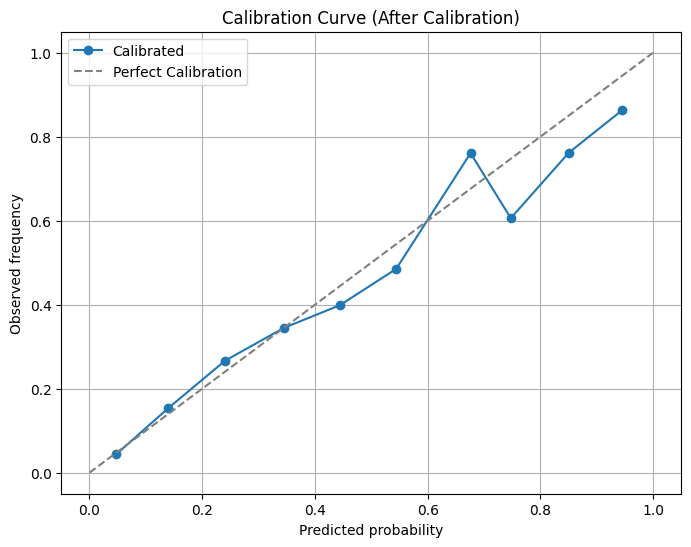

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_pred_proba_calibrated, n_bins=10)

plt.figure(figsize=(8,6))
plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.title('Calibration Curve (After Calibration)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# AUC scores (your existing setup, keep this!)
auc_scores = cross_val_score(
    calibrated_pipeline_logistic, X_train, y_train,
    cv=cv, scoring='roc_auc', n_jobs=-1
)

# Log-loss scores: use built-in scoring string 'neg_log_loss'
logloss_scores = cross_val_score(
    calibrated_pipeline_logistic, X_train, y_train,
    cv=cv, scoring='neg_log_loss', n_jobs=-1
)

# Convert negative log-loss to positive for interpretability
logloss_scores = -logloss_scores

print(f"Cross-validated AUC: mean={auc_scores.mean():.3f}, std={auc_scores.std():.3f}")
print(f"Cross-validated Log-Loss: mean={logloss_scores.mean():.3f}, std={logloss_scores.std():.3f}")

cv_results = pd.DataFrame({
    'AUC': auc_scores,
    'Log-Loss': logloss_scores
})

print(cv_results)

Cross-validated AUC: mean=0.809, std=0.003
Cross-validated Log-Loss: mean=0.278, std=0.002
        AUC  Log-Loss
0  0.810310  0.278375
1  0.809269  0.279013
2  0.809510  0.275792
3  0.813868  0.275637
4  0.804186  0.278977


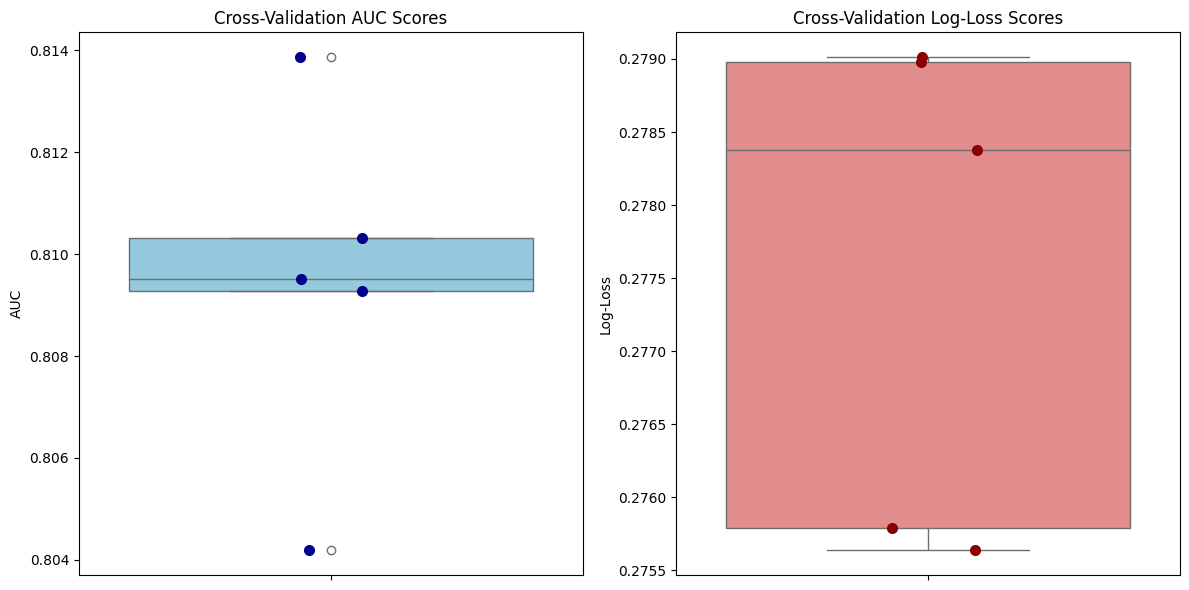

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=cv_results['AUC'], color='skyblue')
sns.stripplot(y=cv_results['AUC'], color='darkblue', jitter=0.1, size=8)
plt.title('Cross-Validation AUC Scores')
plt.ylabel('AUC')

plt.subplot(1, 2, 2)
sns.boxplot(y=cv_results['Log-Loss'], color='lightcoral')
sns.stripplot(y=cv_results['Log-Loss'], color='darkred', jitter=0.1, size=8)
plt.title('Cross-Validation Log-Loss Scores')
plt.ylabel('Log-Loss')

plt.tight_layout()
plt.show()


Bayesian Logistic Regression

In [9]:
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [ ]:
import pymc as pm
import numpy as np
import arviz as az

from google.colab import drive
drive.mount('/content/drive')

X_train_bayes = X_train_scaled.astype(np.float32)
X_test_bayes = X_test_scaled.astype(np.float32)
y_train_bayes = y_train.values.astype(np.int32)

n_features = X_train_bayes.shape[1]

with pm.Model() as bayesian_logreg:
    intercept = pm.Normal("intercept", mu=0, sigma=5)
    coeffs = pm.Normal("coeffs", mu=0, sigma=5, shape=n_features)
    linear_combination = intercept + pm.math.dot(X_train_bayes, coeffs)
    p = pm.Deterministic("p", pm.math.sigmoid(linear_combination))
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_train_bayes)
    trace = pm.sample(draws=1000, tune=1000, target_accept=0.9, cores=2, return_inferencedata=True)

print(az.summary(trace, var_names=["intercept", "coeffs"], hdi_prob=0.95))

drive_path = "/content/drive/MyDrive/bayesian_logreg_trace.nc"
az.to_netcdf(trace, drive_path)
print(f"Trace saved to {drive_path} successfully!")

from google.colab import files
files.download(drive_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


             mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept  -0.703  2.915    -6.055      4.544      0.232    0.139     161.0   
coeffs[0]  -0.888  0.034    -0.957     -0.828      0.002    0.002     452.0   
coeffs[1]   0.413  0.022     0.375      0.455      0.001    0.001     482.0   
coeffs[2]  -0.425  0.022    -0.465     -0.384      0.001    0.001     619.0   
coeffs[3]   0.015  0.022    -0.025      0.057      0.001    0.001     897.0   
coeffs[4]   0.025  0.013     0.002      0.048      0.000    0.001    1039.0   
coeffs[5]   0.075  0.040    -0.011      0.142      0.002    0.002     534.0   
coeffs[6]   0.279  0.051     0.185      0.381      0.002    0.002     561.0   
coeffs[7]   0.804  0.102     0.602      0.992      0.004    0.004     517.0   
coeffs[8]  -1.460  1.787    -4.622      2.116      0.163    0.092     120.0   
coeffs[9]   0.834  1.784    -2.306      4.460      0.161    0.092     121.0   
coeffs[10] -0.407  1.782    -3.434      3.320      0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
from google.colab import drive
drive.mount('/content/drive')

import arviz as az

drive_path = "/content/drive/MyDrive/bayesian_logreg_trace.nc"  # <-- Drive path
idata = az.from_netcdf(drive_path)

print(idata)
print(az.summary(idata, var_names=["intercept","coeffs"], hdi_prob=0.95))


Mounted at /content/drive
Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
             mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept  -0.809  2.779    -6.070      4.781      0.110    0.069     650.0   
coeffs[0]  -0.890  0.033    -0.956     -0.829      0.001    0.001    1621.0   
coeffs[1]   0.412  0.021     0.369      0.455      0.000    0.000    1902.0   
coeffs[2]  -0.426  0.021    -0.465     -0.384      0.000    0.000    2859.0   
coeffs[3]   0.016  0.020    -0.021      0.055      0.000    0.000    2435.0   
coeffs[4]   0.025  0.015    -0.004      0.052      0.000    0.000    2291.0   
coeffs[5]   0.074  0.038    -0.005      0.148      0.001    0.001    2151.0   
coeffs[6]   0.274  0.051     0.167      0.367      0.001    0.001    2063.0   
coeffs[7]   0.804  0.102     0.596      0.993      0.002    0.003    2709.0   
coeffs[8]  -1.448  1.834    -4.930      2.086      0.099    0.048     338.0   
coeffs[9]   0.843  1.834    -2.

In [11]:
import numpy as np
from scipy.special import expit  # logistic sigmoid

# 1. Extract posterior samples
intercept_samples = idata.posterior["intercept"].stack(samples=("chain", "draw")).values  # (n_samples,)
coeff_samples     = idata.posterior["coeffs"].stack(samples=("chain", "draw")).values     # (n_features, n_samples)

# 2. Prepare X_test in same scale as training
X_test_bayes = X_test_scaled.astype(np.float32)

# 3. Reshape intercept for broadcasting
intercept_samples_2d = intercept_samples[:, np.newaxis]  # (n_samples, 1)

# 4. Compute linear predictor for each sample & test point
linpreds = intercept_samples_2d + np.dot(coeff_samples.T, X_test_bayes.T)  # (n_samples, n_test)

# 5. Convert log-odds → probability
probs = expit(linpreds)  # (n_samples, n_test)

# 6. Mean probability across posterior samples
mean_probs = probs.mean(axis=0)  # (n_test,)

# 7. Class prediction (0/1)
y_hat = (mean_probs >= 0.5).astype(np.int32)

print("First 100 predicted probabilities:", mean_probs[:20])
print("First 100 predicted classes:", y_hat[:20])


First 100 predicted probabilities: [0.01282631 0.11236571 0.06948641 0.00888656 0.09825448 0.07834883
 0.06867037 0.01587832 0.00222853 0.09817717 0.02145794 0.15104349
 0.02785349 0.19633197 0.03420854 0.01483913 0.07046822 0.3233164
 0.09599357 0.16915757]
First 100 predicted classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [29]:
lower = np.percentile(probs, 2.5, axis=0)   # 2.5% quantile
upper = np.percentile(probs, 97.5, axis=0)  # 97.5% quantile

for i in range(20):
    print(f"Point {i}: mean={mean_probs[i]:.3f}, 95% CI=({lower[i]:.3f}, {upper[i]:.3f})")


Point 0: mean=0.013, 95% CI=(0.012, 0.014)
Point 1: mean=0.112, 95% CI=(0.105, 0.120)
Point 2: mean=0.069, 95% CI=(0.066, 0.074)
Point 3: mean=0.009, 95% CI=(0.008, 0.010)
Point 4: mean=0.098, 95% CI=(0.090, 0.106)
Point 5: mean=0.078, 95% CI=(0.074, 0.083)
Point 6: mean=0.069, 95% CI=(0.064, 0.073)
Point 7: mean=0.016, 95% CI=(0.014, 0.018)
Point 8: mean=0.002, 95% CI=(0.002, 0.003)
Point 9: mean=0.098, 95% CI=(0.090, 0.107)
Point 10: mean=0.021, 95% CI=(0.019, 0.024)
Point 11: mean=0.151, 95% CI=(0.123, 0.184)
Point 12: mean=0.028, 95% CI=(0.025, 0.031)
Point 13: mean=0.196, 95% CI=(0.184, 0.208)
Point 14: mean=0.034, 95% CI=(0.031, 0.038)
Point 15: mean=0.015, 95% CI=(0.013, 0.017)
Point 16: mean=0.070, 95% CI=(0.067, 0.074)
Point 17: mean=0.323, 95% CI=(0.308, 0.339)
Point 18: mean=0.096, 95% CI=(0.088, 0.105)
Point 19: mean=0.169, 95% CI=(0.156, 0.183)


Bayesian Logistic Regression AUC: 0.805
Bayesian Logistic Regression Accuracy: 0.902
Bayesian Logistic Regression Log-Loss: 0.277


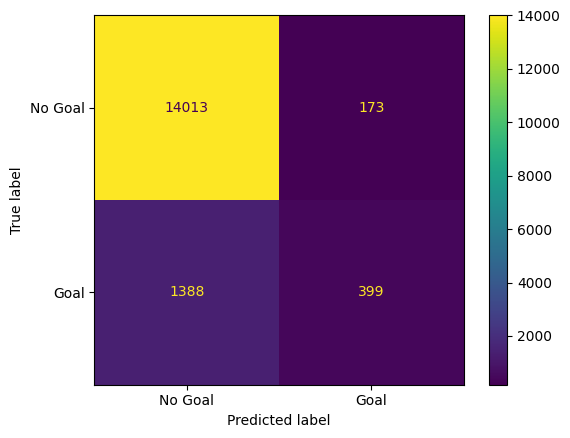

In [30]:
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

# Choose threshold
threshold = 0.5
y_pred_bayes = (mean_probs >= threshold).astype(int)

# Metrics
auc = roc_auc_score(y_test, mean_probs)
acc = accuracy_score(y_test, y_pred_bayes)
ll = log_loss(y_test, mean_probs)

print(f"Bayesian Logistic Regression AUC: {auc:.3f}")
print(f"Bayesian Logistic Regression Accuracy: {acc:.3f}")
print(f"Bayesian Logistic Regression Log-Loss: {ll:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_bayes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Goal", "Goal"])
disp.plot(values_format='d')


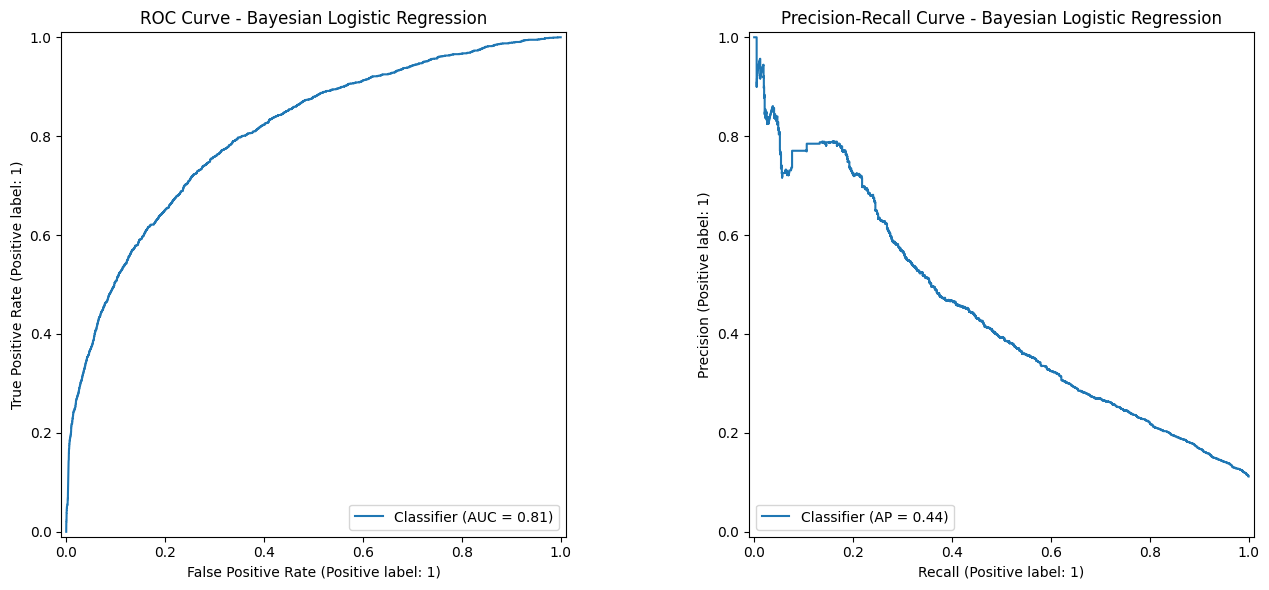

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

roc_display = RocCurveDisplay.from_predictions(y_test, mean_probs, ax=axes[0])
axes[0].set_title("ROC Curve - Bayesian Logistic Regression")

pr_display = PrecisionRecallDisplay.from_predictions(y_test, mean_probs, ax=axes[1])
axes[1].set_title("Precision-Recall Curve - Bayesian Logistic Regression")

plt.tight_layout()
plt.show()


Optimal threshold: 0.20
Precision at optimal threshold: 0.411
Recall at optimal threshold: 0.477
F1 at optimal threshold: 0.442


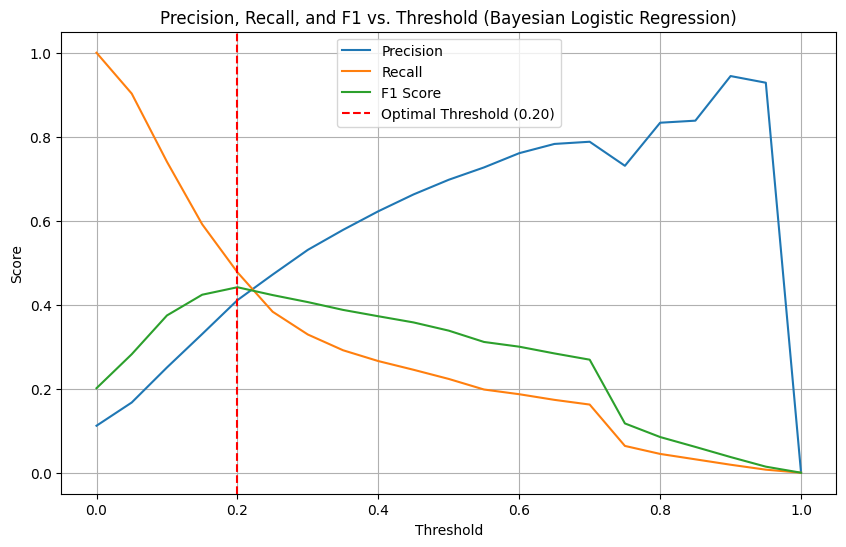

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.0, 1.01, 0.05)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred_thresh = (mean_probs >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_thresh, zero_division=0))
    f1s.append(f1_score(y_test, y_pred_thresh, zero_division=0))

optimal_idx = np.argmax(f1s)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Precision at optimal threshold: {precisions[optimal_idx]:.3f}")
print(f"Recall at optimal threshold: {recalls[optimal_idx]:.3f}")
print(f"F1 at optimal threshold: {f1s[optimal_idx]:.3f}")

# Plot threshold tuning curve
plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs. Threshold (Bayesian Logistic Regression)')
plt.legend()
plt.grid(True)
plt.show()


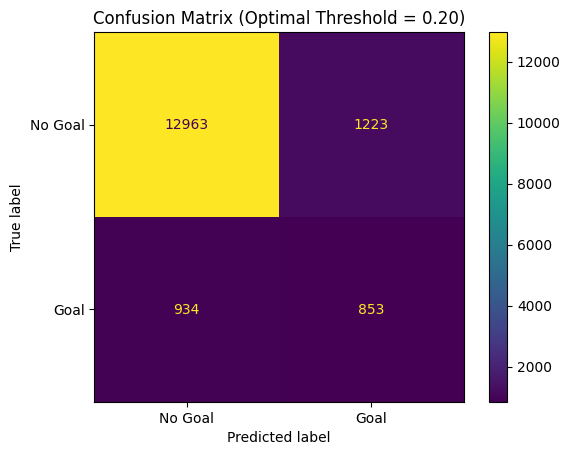

In [27]:
y_pred_optimal = (mean_probs >= optimal_threshold).astype(int)

cm_opt = confusion_matrix(y_test, y_pred_optimal)
disp_opt = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=["No Goal", "Goal"])
disp_opt.plot(values_format='d')
plt.title(f"Confusion Matrix (Optimal Threshold = {optimal_threshold:.2f})")
plt.show()


In [36]:
import arviz as az

# Summarize posterior coefficients
summary = az.summary(idata, var_names=["coeffs"], hdi_prob=0.95)

# Replace index names with your actual feature names
summary.index = feature_columns
summary.index.name = "Feature"

# Display clean table
print(summary)


                          mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  \
Feature                                                                 
distance_to_goal        -0.890  0.033    -0.956     -0.829      0.001   
angle_to_goal_deg        0.412  0.021     0.369      0.455      0.000   
opponents_in_way        -0.426  0.021    -0.465     -0.384      0.000   
teammates_in_way         0.016  0.020    -0.021      0.055      0.000   
with_dominant_foot       0.025  0.015    -0.004      0.052      0.000   
shot_first_time          0.074  0.038    -0.005      0.148      0.001   
shot_one_on_one          0.274  0.051     0.167      0.367      0.001   
shot_open_goal           0.804  0.102     0.596      0.993      0.002   
technique_Backheel      -1.448  1.834    -4.930      2.086      0.099   
technique_Diving Header  0.843  1.834    -2.428      4.607      0.101   
technique_Half Volley   -0.397  1.829    -3.856      3.161      0.101   
technique_Lob            1.251  1.828    -1.987    

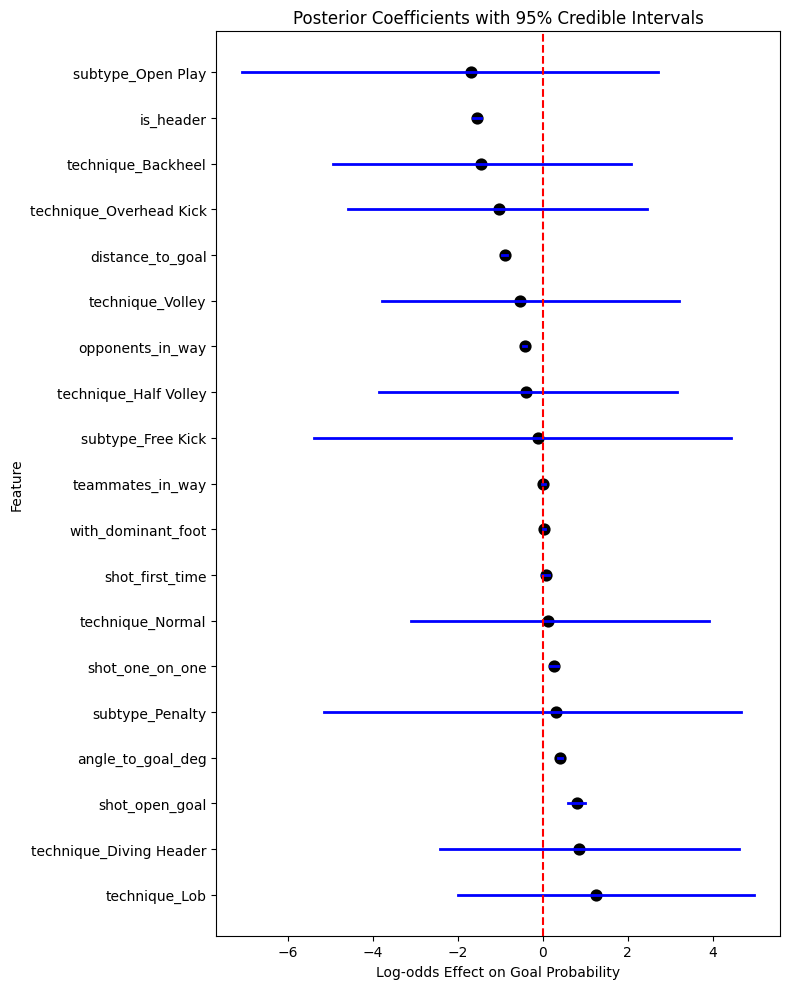

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# Get summary with HDI and feature names
summary = az.summary(idata, var_names=["coeffs"], hdi_prob=0.95)
summary.index = feature_columns

# Sort by mean effect size (optional)
summary = summary.sort_values("mean")

# Create horizontal error bar plot
plt.figure(figsize=(8, 10))
sns.pointplot(
    x=summary["mean"],
    y=summary.index,
    join=False,
    color="black"
)

# Add error bars for the 95% credible intervals
for i, (mean, low, high) in enumerate(zip(summary["mean"], summary["hdi_2.5%"], summary["hdi_97.5%"])):
    plt.plot([low, high], [i, i], color="blue", lw=2)

plt.axvline(0, color="red", linestyle="--")
plt.title("Posterior Coefficients with 95% Credible Intervals")
plt.xlabel("Log-odds Effect on Goal Probability")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


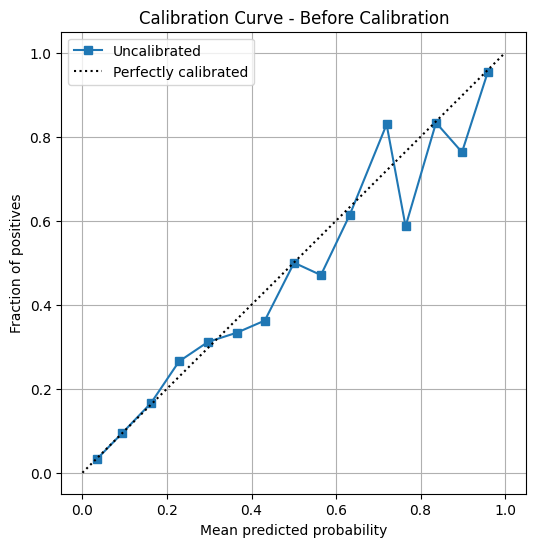

In [47]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, mean_probs, n_bins=15, strategy='uniform'
)

plt.figure(figsize=(6,6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Uncalibrated")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve - Before Calibration")
plt.legend()
plt.grid(True)
plt.show()


In [42]:
from sklearn.linear_model import LogisticRegression

# Train calibration model on validation set
calibration_model = LogisticRegression()
calibration_model.fit(mean_probs.reshape(-1,1), y_test)

# Apply calibration
calibrated_probs = calibration_model.predict_proba(mean_probs.reshape(-1,1))[:,1]


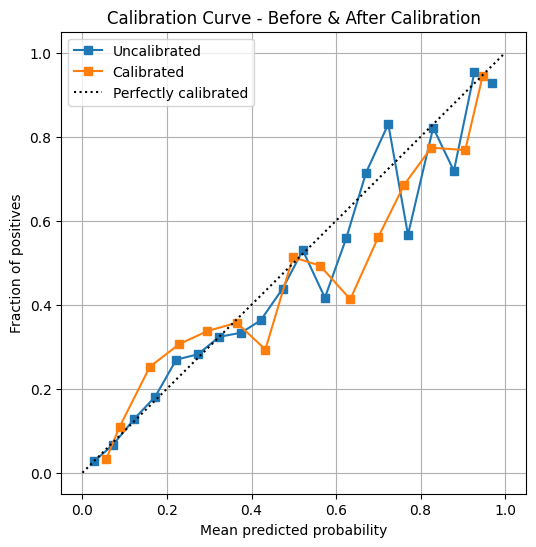

In [46]:
fraction_of_positives_cal, mean_predicted_value_cal = calibration_curve(
    y_test, calibrated_probs, n_bins=15, strategy='uniform'
)

plt.figure(figsize=(6,6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Uncalibrated")
plt.plot(mean_predicted_value_cal, fraction_of_positives_cal, "s-", label="Calibrated")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve - Before & After Calibration")
plt.legend()
plt.grid(True)
plt.show()


In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
import pymc as pm
import arviz as az

def ci95(a):
    return np.percentile(a, [2.5, 97.5])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_rows = []                 # per-fold summaries (mean & 95% CI)
pooled_auc_draws = []          # concatenate all AUC draws across folds
pooled_logloss_draws = []      # concatenate all LogLoss draws across folds

for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), start=1):
    print(f"Running fold {fold_idx}/5...")

    # 1) Split
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # 2) Fit preprocessing on TRAIN fold only (no leakage), transform both
    X_tr_scaled = preprocessor.fit_transform(X_tr)
    X_val_scaled = preprocessor.transform(X_val)

    # 3) Numpy / dtype
    X_tr_bayes = X_tr_scaled.astype(np.float32)
    X_val_bayes = X_val_scaled.astype(np.float32)
    y_tr_bayes = y_tr.values.astype(np.int32)

    # 4) Bayesian logistic regression on this fold
    with pm.Model() as bayesian_logreg_cv:
        intercept = pm.Normal("intercept", mu=0, sigma=5)
        coeffs    = pm.Normal("coeffs",    mu=0, sigma=5, shape=X_tr_bayes.shape[1])

        lin = intercept + pm.math.dot(X_tr_bayes, coeffs)
        p   = pm.Deterministic("p", pm.math.sigmoid(lin))
        y_observed = pm.Bernoulli("y_obs", p=p, observed=y_tr_bayes)

        trace_cv = pm.sample(
            draws=500, tune=500, target_accept=0.9,
            chains=2, cores=2, return_inferencedata=True,
            progressbar=False, random_seed=42
        )

    # 5) Posterior-draw predictions on the VALIDATION fold (manual & fast)
    #    Shapes:
    #      intercept_samples: (S,)
    #      coeff_samples:     (S, n_features)
    intercept_samples = trace_cv.posterior["intercept"].stack(samples=("chain","draw")).values
    coeff_samples     = trace_cv.posterior["coeffs"].stack(samples=("chain","draw")).values  # (S, F)

    # linpreds: (S, n_val)  =  (S,1) + (S,F) @ (F, n_val)
    linpreds = intercept_samples[:, None] + coeff_samples @ X_val_bayes.T
    probs    = 1.0 / (1.0 + np.exp(-linpreds))  # (S, n_val)

    # 6) Metrics per posterior draw (distribution over draws)
    auc_draws = np.array([roc_auc_score(y_val, probs[i, :]) for i in range(probs.shape[0])])
    ll_draws  = np.array([log_loss(y_val, probs[i, :], labels=[0, 1]) for i in range(probs.shape[0])])

    auc_mean = auc_draws.mean()
    auc_lo, auc_hi = ci95(auc_draws)

    ll_mean = ll_draws.mean()
    ll_lo,  ll_hi  = ci95(ll_draws)

    fold_rows.append({
        "fold": fold_idx,
        "AUC_mean": auc_mean, "AUC_2.5%": auc_lo, "AUC_97.5%": auc_hi,
        "LogLoss_mean": ll_mean, "LogLoss_2.5%": ll_lo, "LogLoss_97.5%": ll_hi,
        "n_val": len(y_val)
    })

    # For pooled posterior over performance (across folds)
    pooled_auc_draws.append(auc_draws)
    pooled_logloss_draws.append(ll_draws)

# Per-fold table
cv_posterior = pd.DataFrame(fold_rows)
print("\nPer-fold posterior metric summaries (mean and 95% CI):")
print(cv_posterior.round(3))

# Aggregate across folds (mean of fold means)
print("\nAggregate (mean of fold means):")
print(pd.Series({
    "AUC_mean": cv_posterior["AUC_mean"].mean(),
    "AUC_std" : cv_posterior["AUC_mean"].std(),
    "LogLoss_mean": cv_posterior["LogLoss_mean"].mean(),
    "LogLoss_std" : cv_posterior["LogLoss_mean"].std(),
}).round(3))

# Pooled posterior across all folds (concatenate all draws; interpret as distribution over re-fits & splits)
pooled_auc_draws = np.concatenate(pooled_auc_draws)
pooled_logloss_draws = np.concatenate(pooled_logloss_draws)

def summarize(name, arr):
    lo, hi = ci95(arr)
    print(f"{name}: mean={arr.mean():.3f}, 95% CI=({lo:.3f}, {hi:.3f})")

print("\nPooled posterior over CV folds:")
summarize("AUC", pooled_auc_draws)
summarize("LogLoss", pooled_logloss_draws)


Running fold 1/5...


ValueError: Not enough samples to build a trace.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(pooled_auc_draws, bins=30)
plt.title("Posterior of AUC (pooled across folds)")
plt.xlabel("AUC"); plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(pooled_logloss_draws, bins=30)
plt.title("Posterior of Log-Loss (pooled across folds)")
plt.xlabel("Log-Loss"); plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [ ]:
# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=cv_results['AUC'], color='skyblue')
sns.stripplot(y=cv_results['AUC'], color='darkblue', jitter=0.1, size=8)
plt.title('Cross-Validation AUC Scores')
plt.ylabel('AUC')

plt.subplot(1, 2, 2)
sns.boxplot(y=cv_results['Log-Loss'], color='lightcoral')
sns.stripplot(y=cv_results['Log-Loss'], color='darkred', jitter=0.1, size=8)
plt.title('Cross-Validation Log-Loss Scores')
plt.ylabel('Log-Loss')

plt.tight_layout()
plt.show()


Neural Network

In [50]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

pipeline_nn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(32, 16),  # you can adjust layer sizes
        activation='relu',            # nonlinear activation in hidden layers
        solver='adam',                # good default optimizer
        max_iter=200,                 # increase if not converging
        early_stopping=True,          # stop training if no improvement
        random_state=42
    ))
])


In [51]:
pipeline_nn.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['distance_to_goal',
                                                   'angle_to_goal_deg',
                                                   'opponents_in_way',
                                                   'teammates_in_way',
                                                   'with_dominant_foot']),
                                                 ('bin', 'passthrough',
                                                  ['shot_first_time',
                                                   'shot_one_on_one',
                                                   'shot_open_goal',
                                                   'technique_Backheel',
                                                   'technique_Diving Header',
                                                   'technique_Half Volley',
                                                   'technique_Lob',
                                                   'technique_Normal',
                                                   'technique_Overhead Kick',
                                                   'technique_Volley',
                                                   'subtype_Free Kick',
                                                   'subtype_Open Play',
                                                   'subtype_Penalty',
                                                   'is_header'])])),
                ('classifier',
                 MLPClassifier(early_stopping=True, hidden_layer_sizes=(32, 16),
                               random_state=42))])

In [52]:
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss

y_pred_proba_nn = pipeline_nn.predict_proba(X_test)[:, 1]
y_pred_nn = pipeline_nn.predict(X_test)

auc_nn = roc_auc_score(y_test, y_pred_proba_nn)
acc_nn = accuracy_score(y_test, y_pred_nn)
ll_nn = log_loss(y_test, y_pred_proba_nn)

print(f"Neural Network AUC: {auc_nn:.3f}")
print(f"Neural Network Accuracy: {acc_nn:.3f}")
print(f"Neural Network Log-Loss: {ll_nn:.3f}")


Neural Network AUC: 0.809
Neural Network Accuracy: 0.904
Neural Network Log-Loss: 0.273


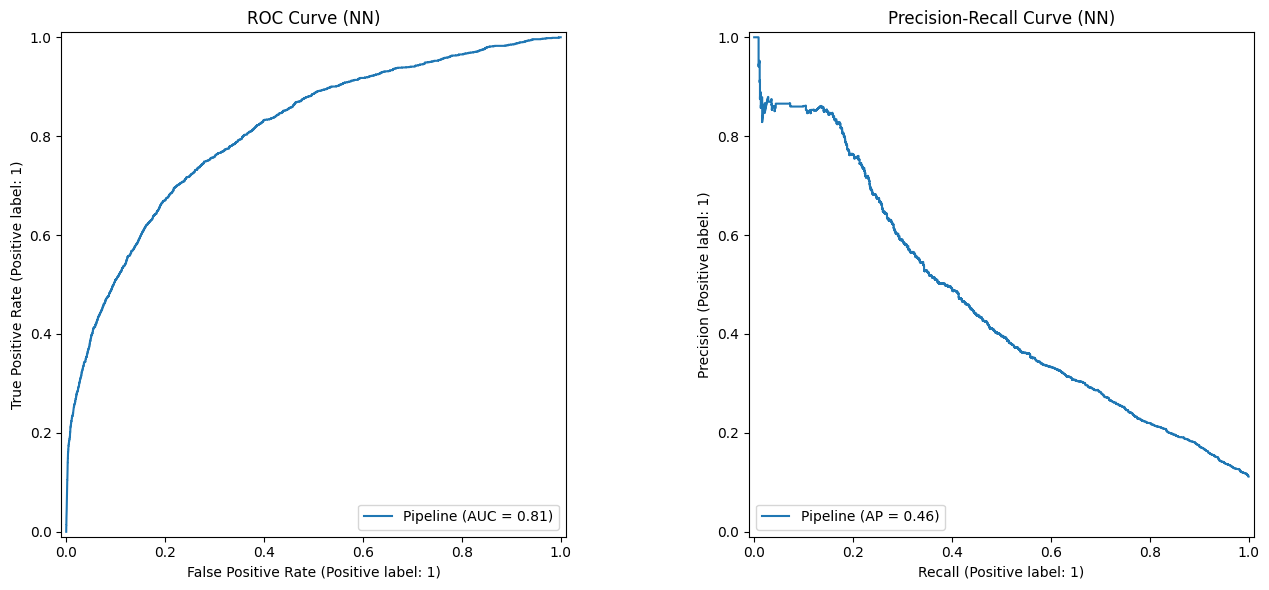

In [53]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
RocCurveDisplay.from_estimator(pipeline_nn, X_test, y_test, ax=axes[0])
axes[0].set_title("ROC Curve (NN)")

PrecisionRecallDisplay.from_estimator(pipeline_nn, X_test, y_test, ax=axes[1])
axes[1].set_title("Precision-Recall Curve (NN)")

plt.tight_layout()
plt.show()


In [54]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.0, 1.01, 0.05)
precisions, recalls, f1s = [], [], []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba_nn >= threshold).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_thresh, zero_division=0))
    f1s.append(f1_score(y_test, y_pred_thresh, zero_division=0))

optimal_idx = np.argmax(f1s)
optimal_threshold_nn = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold_nn:.2f}")
print(f"Precision at optimal threshold: {precisions[optimal_idx]:.3f}")
print(f"Recall at optimal threshold: {recalls[optimal_idx]:.3f}")
print(f"F1 at optimal threshold: {f1s[optimal_idx]:.3f}")

Optimal threshold: 0.25
Precision at optimal threshold: 0.455
Recall at optimal threshold: 0.436
F1 at optimal threshold: 0.445


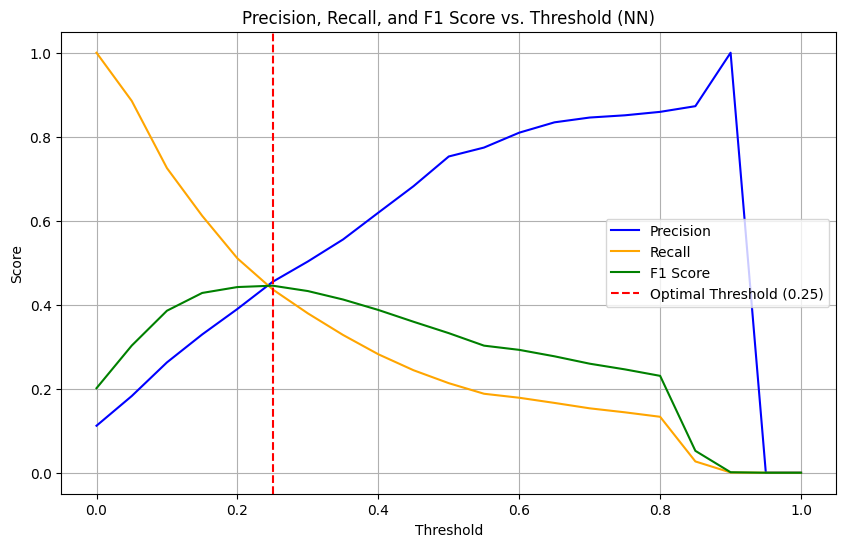

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='orange')
plt.plot(thresholds, f1s, label='F1 Score', color='green')
plt.axvline(optimal_threshold_nn, color='red', linestyle='--', label=f'Optimal Threshold ({optimal_threshold_nn:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold (NN)')
plt.legend()
plt.grid(True)
plt.show()


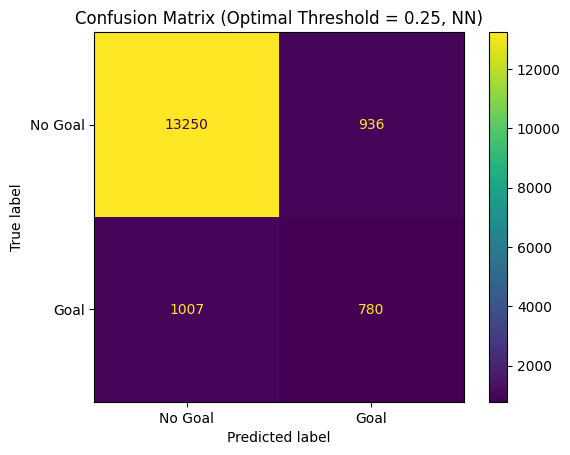

Final Precision (NN): 0.455
Final Recall (NN): 0.436
Final F1 Score (NN): 0.445


In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_optimal_nn = (y_pred_proba_nn >= optimal_threshold_nn).astype(int)

cm_nn = confusion_matrix(y_test, y_pred_optimal_nn)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=["No Goal", "Goal"])
disp_nn.plot(values_format='d')
plt.title(f"Confusion Matrix (Optimal Threshold = {optimal_threshold_nn:.2f}, NN)")
plt.show()

final_precision_nn = precision_score(y_test, y_pred_optimal_nn, zero_division=0)
final_recall_nn = recall_score(y_test, y_pred_optimal_nn, zero_division=0)
final_f1_nn = f1_score(y_test, y_pred_optimal_nn, zero_division=0)

print(f"Final Precision (NN): {final_precision_nn:.3f}")
print(f"Final Recall (NN): {final_recall_nn:.3f}")
print(f"Final F1 Score (NN): {final_f1_nn:.3f}")

In [57]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cv_nn = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores_nn = cross_val_score(
    pipeline_nn, X_train, y_train,
    cv=cv_nn, scoring='roc_auc', n_jobs=-1
)

logloss_scores_nn = cross_val_score(
    pipeline_nn, X_train, y_train,
    cv=cv_nn, scoring='neg_log_loss', n_jobs=-1
)
logloss_scores_nn = -logloss_scores_nn

print(f"Cross-validated AUC (NN): mean={auc_scores_nn.mean():.3f}, std={auc_scores_nn.std():.3f}")
print(f"Cross-validated Log-Loss (NN): mean={logloss_scores_nn.mean():.3f}, std={logloss_scores_nn.std():.3f}")

cv_results_nn = pd.DataFrame({'AUC': auc_scores_nn, 'Log-Loss': logloss_scores_nn})

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.boxplot(y=cv_results_nn['AUC'], color='lightblue')
sns.stripplot(y=cv_results_nn['AUC'], color='darkblue', jitter=0.1, size=8)
plt.title('Cross-Validation AUC Scores (NN)')

plt.subplot(1, 2, 2)
sns.boxplot(y=cv_results_nn['Log-Loss'], color='lightcoral')
sns.stripplot(y=cv_results_nn['Log-Loss'], color='darkred', jitter=0.1, size=8)
plt.title('Cross-Validation Log-Loss Scores (NN)')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Compute permutation importance on test data
result = permutation_importance(
    pipeline_nn, X_test, y_test,
    n_repeats=10, random_state=42, scoring='roc_auc'
)

# Collect results into a DataFrame
importances_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance Mean', ascending=False)

print(importances_df)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance Mean',
    y='Feature',
    data=importances_df,
    palette='viridis'
)
plt.title('Permutation Feature Importance (NN)')
plt.xlabel('Mean decrease in AUC')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Get predicted probabilities from your uncalibrated NN
y_pred_proba_nn = pipeline_nn.predict_proba(X_test)[:, 1]

# Compute calibration curve
frac_pos, mean_pred = calibration_curve(y_test, y_pred_proba_nn, n_bins=20)

# Plot calibration curve
plt.figure(figsize=(7,5))
plt.plot(mean_pred, frac_pos, marker='o', label='Uncalibrated NN')
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.title('Calibration Curve (Neural Network - Before Calibration)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.calibration import CalibratedClassifierCV

# Wrap your trained NN pipeline with CalibratedClassifierCV
calibrated_pipeline_nn = CalibratedClassifierCV(
    estimator=pipeline_nn,
    method='sigmoid',    # or try 'isotonic' for non-parametric calibration
    cv='prefit'          # use the already trained pipeline
)

# Fit calibration on the test set (or better: on a separate validation set if available)
calibrated_pipeline_nn.fit(X_test, y_test)


In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Predict calibrated probabilities
y_calibrated_proba_nn = calibrated_pipeline_nn.predict_proba(X_test)[:, 1]

# Compute calibration curve after calibration
frac_pos_cal, mean_pred_cal = calibration_curve(y_test, y_calibrated_proba_nn, n_bins=20)

# Plot calibrated vs. perfect calibration
plt.figure(figsize=(7,5))
plt.plot(mean_pred_cal, frac_pos_cal, marker='o', label='Calibrated NN')
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.title('Calibration Curve (Neural Network - After Calibration)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score, log_loss

cal_auc = roc_auc_score(y_test, y_calibrated_proba_nn)
cal_logloss = log_loss(y_test, y_calibrated_proba_nn)

print(f"Calibrated NN AUC: {cal_auc:.3f}")
print(f"Calibrated NN Log-Loss: {cal_logloss:.3f}")

Bayesian Neural Network

In [1]:
import pymc as pm
import arviz as az
print(pm.__version__, az.__version__)


5.25.1 0.22.0


In [ ]:
import pymc as pm
import numpy as np
import arviz as az
from google.colab import drive
from google.colab import files

# Mount Google Drive
drive.mount('/content/drive')

# Prepare data
X_train_bayes = X_train_scaled.astype(np.float32)
y_train_bayes = y_train.values.astype(np.int32)

n_features = X_train_bayes.shape[1]
n_hidden   = 5  # smaller hidden layer

with pm.Model() as bnn_small:
    # Priors
    w_hidden = pm.Normal("w_hidden", 0, 0.5, shape=(n_features, n_hidden))
    b_hidden = pm.Normal("b_hidden", 0, 0.5, shape=(n_hidden,))
    hidden   = pm.math.tanh(pm.math.dot(X_train_bayes, w_hidden) + b_hidden)

    w_out = pm.Normal("w_out", 0, 0.5, shape=(n_hidden,))
    b_out = pm.Normal("b_out", 0, 0.5)

    # Output layer
    lin = pm.math.dot(hidden, w_out) + b_out
    p   = pm.Deterministic("p", pm.math.sigmoid(lin))

    # Likelihood
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_train_bayes)

    # Sampling
    trace_bnn_small = pm.sample(
        draws=400, tune=400,
        chains=2, cores=2,
        target_accept=0.9,
        return_inferencedata=True,
        progressbar=True,
        random_seed=42
    )

# Summary
print(az.summary(trace_bnn_small, var_names=["w_out","b_out"], hdi_prob=0.95))

# File path in Google Drive
drive_path = "/content/drive/MyDrive/bnn_small_trace.nc"

# Save to Google Drive
az.to_netcdf(trace_bnn_small, drive_path)
print(f"Trace saved to Google Drive: {drive_path}")

# ALSO save locally
local_path = "/content/bnn_small_trace.nc"
az.to_netcdf(trace_bnn_small, local_path)
files.download(local_path)  # Download to your machine

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Output()

In [ ]:
import arviz as az

drive_path = "/content/drive/MyDrive/bnn_small_trace.nc"
trace_bnn_small = az.from_netcdf(drive_path)
print("Trace loaded successfully!")


In [ ]:
from scipy.special import expit
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Prepare test data
X_test_bayes = X_test_scaled.astype(np.float32)

# Extract posterior samples
w_h = trace_bnn_small.posterior["w_hidden"].stack(s=("chain","draw")).values  # (F,H,S)
b_h = trace_bnn_small.posterior["b_hidden"].stack(s=("chain","draw")).values  # (H,S)
w_o = trace_bnn_small.posterior["w_out"].stack(s=("chain","draw")).values     # (H,S)
b_o = trace_bnn_small.posterior["b_out"].stack(s=("chain","draw")).values     # (S,)

S = w_h.shape[-1]
probs = np.empty((S, X_test_bayes.shape[0]), dtype=np.float32)

# Compute predictions for each posterior sample
for i in range(S):
    hidden = np.tanh(X_test_bayes @ w_h[..., i] + b_h[..., i])
    lin    = hidden @ w_o[..., i] + b_o[i]
    probs[i, :] = expit(lin)

# Mean predicted probabilities
mean_probs = probs.mean(axis=0)

# Binary predictions
y_pred = (mean_probs >= 0.5).astype(int)

# Metrics
auc = roc_auc_score(y_test, mean_probs)
ll  = log_loss(y_test, mean_probs)
acc = accuracy_score(y_test, y_pred)

print(f"BNN Small - AUC: {auc:.3f}, Accuracy: {acc:.3f}, Log-Loss: {ll:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Goal", "Goal"])
disp.plot(values_format='d')
